In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
!pip install lightgbm

In [4]:
from joblib import Parallel, delayed

In [5]:
from tqdm import tqdm 

In [6]:
import category_encoders as ce

In [7]:
import gc

In [13]:
!pip install --upgrade numpy lightgbm dask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: dask
    Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0


In [8]:
import lightgbm as lgbm

In [9]:
from sklearn.metrics import make_scorer

In [10]:
from sklearn.model_selection import RandomizedSearchCV
import os
np.random.seed(4011)

In [11]:
input_dir = '/Users/emilyli/OneDrive - The Chinese University of Hong Kong/STAT4011 jupyter Notebooks/Task 2/'

In [12]:
book_train = pd.read_parquet('/Users/emilyli/OneDrive - The Chinese University of Hong Kong/STAT4011 jupyter Notebooks/Task 2/book_train.parquet/stock_id=0')
book_train

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28


In [14]:
trade_train = pd.read_parquet("/Users/emilyli/OneDrive - The Chinese University of Hong Kong/STAT4011 jupyter Notebooks/Task 2/trade_train.parquet/stock_id=0")
trade_train

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
...,...,...,...,...,...
123438,32767,471,0.998659,200,3
123439,32767,517,0.998515,90,1
123440,32767,523,0.998563,1,1
123441,32767,542,0.998803,90,4


In [15]:
train = pd.read_csv('/Users/emilyli/OneDrive - The Chinese University of Hong Kong/STAT4011 jupyter Notebooks/Task 2/train.csv')
test = pd.read_csv('/Users/emilyli/OneDrive - The Chinese University of Hong Kong/STAT4011 jupyter Notebooks/Task 2/test.csv')
train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


In [16]:
test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [17]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)

In [18]:
INPUT_DIR = '/Users/emilyli/OneDrive - The Chinese University of Hong Kong/STAT4011 jupyter Notebooks/Task 2/'

def read_train_test():
    train = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
    test = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
    # row_id: stock_id-time_id
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    return train, test

train, test = read_train_test()

In [19]:
train_stock_ids = train['stock_id'].unique()
train_stock_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  46,  47,  48,  50,  51,  52,  53,  55,  56,  58,
        59,  60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  72,  73,
        74,  75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       118, 119, 120, 122, 123, 124, 125, 126])

In [20]:
train

,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62
...,...,...,...,...
428927,126,32751,0.003461,126-32751
428928,126,32753,0.003113,126-32753
428929,126,32758,0.004070,126-32758
428930,126,32763,0.003357,126-32763


In [21]:
stock_id = 0
file_path_book = input_dir + "book_train.parquet/stock_id=" + str(stock_id)
file_path_trade = input_dir + "trade_train.parquet/stock_id=" + str(stock_id)

# Feature engineering


In [22]:
# wap
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# log return
def log_return(wap):
    return np.log(wap).diff()

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def get_stats_window(df, feature_dict,seconds_in_bucket, add_suffix = False):
    df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(feature_dict).reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]
    if add_suffix:
        df_feature = df_feature.add_suffix(str(seconds_in_bucket)) #改列名为“xxx_seconds_in_bucket"
    
    return df_feature

In [23]:
def book_pre(file_path):
    
    df = pd.read_parquet(file_path)
    
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)

    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return).reset_index(drop=True)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return).reset_index(drop=True)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return).reset_index(drop=True)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return).reset_index(drop=True)
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])

    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['bid_ask_spread'] = abs(df['bid_spread'] - df['ask_spread'])

    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    #dict for aggregate
    create_feature_dict = {
        'wap1': ['sum', 'std'],
        'wap2': ['sum', 'std'],
        'wap3': ['sum', 'std'],
        'wap4': ['sum', 'std'],
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        'wap_balance': ['mean'],
        'price_spread': ['mean'],
        'bid_spread': ['mean'],
        'ask_spread': ['mean'],
        'bid_ask_spread': ['mean'],
        'volume_imbalance': ['mean'],
        'total_volume': ['mean']
        }
    
    df_feature = get_stats_window(df, create_feature_dict, seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(df, create_feature_dict, seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(df, create_feature_dict, seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(df, create_feature_dict, seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(df, create_feature_dict, seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(df, create_feature_dict, seconds_in_bucket = 100, add_suffix = True)

    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id_500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id_400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id_300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id_200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id_100')
    
    # Drop unnecesary time_ids
    df_feature.drop(['time_id_500','time_id_400', 'time_id_300', 'time_id_200','time_id_100'], axis = 1, inplace = True) 

    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    
    return df_feature

In [24]:
# Function to preprocess trade data (for each stock id)
def trade_pre(file_path):
    
    df = pd.read_parquet(file_path)
    
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return).reset_index(drop=True)
    df['amount'] = df['price'] * df['size']
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return': [realized_volatility],  
        'size': ['sum', 'max', 'min'],        
        'order_count': ['sum', 'max', 'min'], 
        'amount': ['sum', 'min', 'std']       
    }

    df_feature = get_stats_window(df, create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(df, create_feature_dict, seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(df, create_feature_dict, seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(df, create_feature_dict, seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(df, create_feature_dict, seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(df, create_feature_dict, seconds_in_bucket = 100, add_suffix = True)

    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id_500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id_400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id_300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id_200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id_100')
    
    # Drop unnecesary time_ids
    df_feature.drop(['time_id_500','time_id_400', 'time_id_300', 'time_id_200','time_id_100'], axis = 1, inplace = True) #time_id_500, time_id_400 等列是通过 get_stats_window 函数生成的

    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    
    return df_feature

In [25]:
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(stock_ids, is_train = True):
    
    # Parrallel：stock_id是stock_ids中的元素
    def preprocessing(stock_id):
        # Train
        if is_train:
            file_path_book = INPUT_DIR + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = INPUT_DIR + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = INPUT_DIR + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = INPUT_DIR + "trade_test.parquet/stock_id=" + str(stock_id)
           # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_pre(file_path_book), trade_pre(file_path_trade), on = 'row_id', how = 'left')

        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(preprocessing)(stock_id) for stock_id in tqdm(stock_ids))
    df = pd.concat(df, ignore_index = True)
    
    return df
 

In [26]:
def get_time_stock(df):
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']
#创建下文的索引，为什么没有log return 3,4...，这个function好像没有在后期被用到？

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df

In [27]:
train_stock_ids = train['stock_id'].unique()

df_train = preprocessor(train_stock_ids, is_train = True)

df_train_tmp = train.copy()
df_train_tmp = df_train_tmp[['row_id', 'target']]
df_train = pd.merge(
    df_train, df_train_tmp,
    on = ['row_id'], how = 'right'
)
df_train['stock_id'] = df_train['row_id'].apply(lambda x: int(x.split('-')[0])).astype('category')
df_train

100%|█████████████████████████████████████████| 112/112 [12:12<00:00,  6.54s/it]
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 13.3min finished


,wap1_sum,wap1_std,wap2_sum,wap2_std,wap3_sum,wap3_std,wap4_sum,wap4_std,log_return1_realized_volatility,log_return2_realized_volatility,...,size_max100,size_min100,order_count_sum100,order_count_max100,order_count_min100,amount_sum100,amount_min100,amount_std100,target,stock_id
0,303.125061,0.000693,303.105539,0.000781,303.134863,0.000637,303.146936,0.000652,0.004499,0.006999,...,499.0,1.0,82.0,9.0,1.0,2419.977786,1.002715,119.757452,0.004136,0
1,200.047768,0.000262,200.041171,0.000272,200.035611,0.000298,200.040851,0.000278,0.001204,0.002476,...,280.0,1.0,50.0,6.0,1.0,1174.351443,0.999925,82.621822,0.001445,0
2,187.913849,0.000864,187.939824,0.000862,187.923063,0.000670,187.897375,0.000779,0.002369,0.004801,...,391.0,1.0,63.0,8.0,1.0,2029.654090,0.999928,116.785821,0.002168,0
3,119.859781,0.000757,119.835941,0.000656,119.870163,0.000606,119.884240,0.000733,0.002574,0.003637,...,450.0,5.0,57.0,15.0,1.0,1930.598837,4.991672,147.645679,0.002195,0
4,175.932865,0.000258,175.934256,0.000317,175.928283,0.000215,175.912533,0.000312,0.001894,0.003257,...,341.0,1.0,75.0,17.0,1.0,1573.303741,0.999417,123.413702,0.001747,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,309.870453,0.000486,309.871368,0.000613,309.778625,0.000596,309.812317,0.000594,0.003691,0.005876,...,205.0,1.0,63.0,7.0,1.0,1430.718592,0.998563,63.551968,0.003461,126
428928,223.552139,0.001264,223.580322,0.001303,223.505493,0.001340,223.480896,0.001341,0.004104,0.004991,...,230.0,1.0,117.0,15.0,1.0,1922.508690,1.001103,66.564479,0.003113,126
428929,256.277039,0.000466,256.255066,0.000599,256.146057,0.000520,256.168884,0.000558,0.003117,0.006020,...,498.0,1.0,94.0,8.0,1.0,3637.197700,1.001382,116.975327,0.004070,126
428930,399.721741,0.000456,399.714325,0.000507,399.775391,0.000424,399.779358,0.000429,0.003661,0.005362,...,738.0,1.0,204.0,12.0,1.0,8329.271061,1.001218,143.744540,0.003357,126


In [28]:
test_stock_ids = test['stock_id'].unique()

In [29]:
X_train = df_train.drop(['target', 'row_id'], axis=1)
y_train = df_train['target']

In [30]:
X_train

,wap1_sum,wap1_std,wap2_sum,wap2_std,wap3_sum,wap3_std,wap4_sum,wap4_std,log_return1_realized_volatility,log_return2_realized_volatility,...,size_sum100,size_max100,size_min100,order_count_sum100,order_count_max100,order_count_min100,amount_sum100,amount_min100,amount_std100,stock_id
0,303.125061,0.000693,303.105539,0.000781,303.134863,0.000637,303.146936,0.000652,0.004499,0.006999,...,2411.0,499.0,1.0,82.0,9.0,1.0,2419.977786,1.002715,119.757452,0
1,200.047768,0.000262,200.041171,0.000272,200.035611,0.000298,200.040851,0.000278,0.001204,0.002476,...,1174.0,280.0,1.0,50.0,6.0,1.0,1174.351443,0.999925,82.621822,0
2,187.913849,0.000864,187.939824,0.000862,187.923063,0.000670,187.897375,0.000779,0.002369,0.004801,...,2032.0,391.0,1.0,63.0,8.0,1.0,2029.654090,0.999928,116.785821,0
3,119.859781,0.000757,119.835941,0.000656,119.870163,0.000606,119.884240,0.000733,0.002574,0.003637,...,1933.0,450.0,5.0,57.0,15.0,1.0,1930.598837,4.991672,147.645679,0
4,175.932865,0.000258,175.934256,0.000317,175.928283,0.000215,175.912533,0.000312,0.001894,0.003257,...,1574.0,341.0,1.0,75.0,17.0,1.0,1573.303741,0.999417,123.413702,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,309.870453,0.000486,309.871368,0.000613,309.778625,0.000596,309.812317,0.000594,0.003691,0.005876,...,1432.0,205.0,1.0,63.0,7.0,1.0,1430.718592,0.998563,63.551968,126
428928,223.552139,0.001264,223.580322,0.001303,223.505493,0.001340,223.480896,0.001341,0.004104,0.004991,...,1918.0,230.0,1.0,117.0,15.0,1.0,1922.508690,1.001103,66.564479,126
428929,256.277039,0.000466,256.255066,0.000599,256.146057,0.000520,256.168884,0.000558,0.003117,0.006020,...,3635.0,498.0,1.0,94.0,8.0,1.0,3637.197700,1.001382,116.975327,126
428930,399.721741,0.000456,399.714325,0.000507,399.775391,0.000424,399.779358,0.000429,0.003661,0.005362,...,8313.0,738.0,1.0,204.0,12.0,1.0,8329.271061,1.001218,143.744540,126


In [31]:
y_train

0         0.004136
1         0.001445
2         0.002168
3         0.002195
4         0.001747
            ...   
428927    0.003461
428928    0.003113
428929    0.004070
428930    0.003357
428931    0.002090
Name: target, Length: 428932, dtype: float64

In [32]:
# 初始化 TargetEncoder
t_encoder = ce.TargetEncoder()

# 仅使用 X_train 和 y_train 进行编码
X_train['stock_id'] = t_encoder.fit_transform(X_train['stock_id'], y_train)
X_train

,wap1_sum,wap1_std,wap2_sum,wap2_std,wap3_sum,wap3_std,wap4_sum,wap4_std,log_return1_realized_volatility,log_return2_realized_volatility,...,size_sum100,size_max100,size_min100,order_count_sum100,order_count_max100,order_count_min100,amount_sum100,amount_min100,amount_std100,stock_id
0,303.125061,0.000693,303.105539,0.000781,303.134863,0.000637,303.146936,0.000652,0.004499,0.006999,...,2411.0,499.0,1.0,82.0,9.0,1.0,2419.977786,1.002715,119.757452,0.004028
1,200.047768,0.000262,200.041171,0.000272,200.035611,0.000298,200.040851,0.000278,0.001204,0.002476,...,1174.0,280.0,1.0,50.0,6.0,1.0,1174.351443,0.999925,82.621822,0.004028
2,187.913849,0.000864,187.939824,0.000862,187.923063,0.000670,187.897375,0.000779,0.002369,0.004801,...,2032.0,391.0,1.0,63.0,8.0,1.0,2029.654090,0.999928,116.785821,0.004028
3,119.859781,0.000757,119.835941,0.000656,119.870163,0.000606,119.884240,0.000733,0.002574,0.003637,...,1933.0,450.0,5.0,57.0,15.0,1.0,1930.598837,4.991672,147.645679,0.004028
4,175.932865,0.000258,175.934256,0.000317,175.928283,0.000215,175.912533,0.000312,0.001894,0.003257,...,1574.0,341.0,1.0,75.0,17.0,1.0,1573.303741,0.999417,123.413702,0.004028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,309.870453,0.000486,309.871368,0.000613,309.778625,0.000596,309.812317,0.000594,0.003691,0.005876,...,1432.0,205.0,1.0,63.0,7.0,1.0,1430.718592,0.998563,63.551968,0.005321
428928,223.552139,0.001264,223.580322,0.001303,223.505493,0.001340,223.480896,0.001341,0.004104,0.004991,...,1918.0,230.0,1.0,117.0,15.0,1.0,1922.508690,1.001103,66.564479,0.005321
428929,256.277039,0.000466,256.255066,0.000599,256.146057,0.000520,256.168884,0.000558,0.003117,0.006020,...,3635.0,498.0,1.0,94.0,8.0,1.0,3637.197700,1.001382,116.975327,0.005321
428930,399.721741,0.000456,399.714325,0.000507,399.775391,0.000424,399.779358,0.000429,0.003661,0.005362,...,8313.0,738.0,1.0,204.0,12.0,1.0,8329.271061,1.001218,143.744540,0.005321


In [33]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# 假设 X_train 是特征数据，y_train 是目标变量
# X_train = pd.DataFrame(...)  # 特征数据
# y_train = pd.Series(...)     # 目标变量

# 定义 k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 存储每个特征的重要性
feature_importance = pd.Series(0, index=X_train.columns)

# k-fold 交叉验证
for train_index, test_index in kf.split(X_train):
    X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # 创建 LightGBM 数据集
    d_train = lgb.Dataset(X_fold_train, label=y_fold_train)
    
    # 设置模型参数
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'verbose': -1
    }
    
    # 训练模型
    model = lgb.train(params, d_train, num_boost_round=100)
    
    # 获取特征重要性
    importance = model.feature_importance(importance_type='gain')
    
    # 将当前折叠的特征重要性累加
    feature_importance += importance

# 计算平均特征重要性
feature_importance /= kf.n_splits

# 将特征重要性排序
feature_importance = feature_importance.sort_values(ascending=False)

# 选择最重要的特征（选择前 20 个）
top_features = feature_importance.head(20).index.tolist()
print("Top 20 features:", top_features)

Top 20 features: ['log_return1_realized_volatility100', 'log_return1_realized_volatility200', 'log_return1_realized_volatility', 'log_return3_realized_volatility200', 'log_return1_realized_volatility300', 'log_return2_realized_volatility200', 'log_return3_realized_volatility100', 'log_return2_realized_volatility100', 'log_return3_realized_volatility300', 'log_return2_realized_volatility', 'log_return4_realized_volatility300', 'log_return2_realized_volatility300', 'stock_id', 'log_return1_realized_volatility400', 'log_return3_realized_volatility400', 'log_return4_realized_volatility200', 'log_return3_realized_volatility', 'log_return2_realized_volatility400', 'amount_std', 'log_return_realized_volatility400']


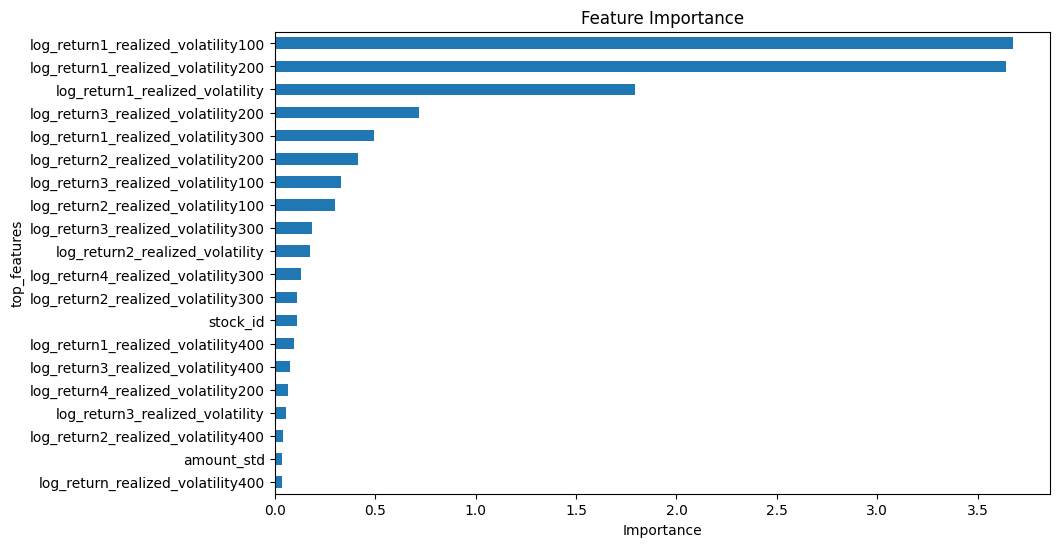

In [34]:
# 可视化特征重要性
plt.figure(figsize=(10, 6))
feature_importance.head(20).sort_values(ascending=True).plot(kind='barh')  # 反向排序
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('top_features')
plt.show()

In [35]:
# Train XGBoost
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

def rmspe(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(
            np.square(((y_true - y_pred) / y_true))))

X_selected = X_train[top_features]

# 定义 k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 存储每个折叠的 RMSPE
rmspe_list = []

# k-fold 交叉验证
for train_index, test_index in kf.split(X_selected):
    X_fold_train, X_fold_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
    y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # 创建 DMatrix 数据格式
    dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train)
    dtest = xgb.DMatrix(X_fold_test, label=y_fold_test)
    
    # 设置模型参数
    params = {
        'objective': 'reg:squarederror',  # 回归问题
        'eval_metric': 'rmse',
        'learning_rate': 0.1,
        'max_depth': 6,
        'alpha': 10
    }
    
    # 训练模型
    num_boost_round = 100  # 设置迭代次数
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    
    # 预测
    y_pred = model.predict(dtest)
    
    # 计算 RMSPE
    rmspe = np.sqrt(np.mean(((y_fold_test - y_pred) / y_fold_test) ** 2))
    rmspe_list.append(rmspe)

# 输出每个折叠的 RMSPE
for i, rmspe in enumerate(rmspe_list):
    print(f'Fold {i + 1} RMSPE: {rmspe:.4f}')

# 输出平均 RMSPE
print(f'Average RMSPE: {np.mean(rmspe_list):.4f}')

Fold 1 RMSPE: 0.3348
Fold 2 RMSPE: 0.3392
Fold 3 RMSPE: 0.3431
Fold 4 RMSPE: 0.3319
Fold 5 RMSPE: 0.3346
Average RMSPE: 0.3367


In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor

In [37]:
# Add GridSearch into Training XGboost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'alpha': [0, 1, 10],
    'n_estimators': [100]  # 可以根据需要调整
}

# 创建 XGBoost 回归模型
xgb_model = XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# 创建 KFold 对象
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 存储每个折叠的最佳参数和得分
results = []

# 手动进行 K-fold 交叉验证
for train_index, test_index in kf.split(X_selected):
    X_train_fold, X_test_fold = X_selected.iloc[train_index], X_selected.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # 创建 GridSearchCV 对象
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                               scoring='neg_root_mean_squared_error', 
                               cv=3, n_jobs=-1, verbose=1)
    
    # 进行超参数搜索
    grid_search.fit(X_train_fold, y_train_fold)
    
    # 在测试集上评估最佳模型
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_fold)
    rmspe = np.sqrt(np.mean(((y_test_fold - y_pred) / y_test_fold) ** 2))
    
    results.append({
        'best_params': grid_search.best_params_,
        'rmspe': rmspe
    })

# 输出每个折叠的结果
for i, result in enumerate(results):
    print(f'Fold {i + 1}: Best Params: {result["best_params"]}, RMSPE: {result["rmspe"]:.4f}')

# 计算平均 RMSPE
average_rmspe = np.mean([result['rmspe'] for result in results])
print(f'Average RMSPE: {average_rmspe:.4f}')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fold 1: Best Params: {'alpha': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}, RMSPE: 0.2842
Fold 2: Best Params: {'alpha': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}, RMSPE: 0.2859
Fold 3: Best Params: {'alpha': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}, RMSPE: 0.2885
Fold 4: Best Params: {'alpha': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}, RMSPE: 0.2796
Fold 5: Best Params: {'alpha': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}, RMSPE: 0.2797
Average RMSPE: 0.2836
